In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox

## Project assumptions:
1. Values in collumn 'Collision ID' are unique.
2. Location coordinates are correct. 
3. Do celów analizy odrzucamy przyczyny wypadków, które sa 'unspecified'.
4. W kolumnie 'BOROUGH' sa wartości NaN. Znaleść dzielnicę po koordynatach lub nazwie ulicy!

# 1. Data loading

In [86]:
# Loading the CSV file with vehicle collision data and assigning the DataFrame to the variable 'vehicle_collision'
vehicle_collision = pd.read_csv('DataSets/nypd-motor-vehicle-collisions.csv',
                                dtype={
                                    'ZIP CODE': str,
                                    'CONTRIBUTING FACTOR VEHICLE 1': str,
                                    'CONTRIBUTING FACTOR VEHICLE 2': str,
                                    'CONTRIBUTING FACTOR Vehicle 3': str,
                                    'CONTRIBUTING FACTOR Vehicle 4': str,
                                    'CONTRIBUTING FACTOR Vehicle 5': str
                                      }
                                )
pd.set_option('display.max_columns', None)
vehicle_collision.head(10)

,ACCIDENT DATE,ACCIDENT TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2019-08-05T00:00:00.000,16:30,QUEENS,11434,40.676052,-73.790184,"{'type': 'Point', 'coordinates': [-73.790184, 40.676052]}",NaN,NaN,150-08 123 AVENUE,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4184637,Sedan,Pick-up Truck,NaN,NaN,NaN
1,2019-08-27T00:00:00.000,16:02,BROOKLYN,11225,40.657780,-73.951096,"{'type': 'Point', 'coordinates': [-73.951096, 40.65778]}",NaN,NaN,288 HAWTHORNE STREET,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4195773,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
2,2019-08-15T00:00:00.000,17:57,MANHATTAN,10002,40.718143,-73.993835,"{'type': 'Point', 'coordinates': [-73.993835, 40.718143]}",CHRYSTIE STREET,GRAND STREET,NaN,1.0,0.0,0,0,0,0,1,0,Driver Inattention/Distraction,NaN,NaN,NaN,NaN,4202457,Sedan,NaN,NaN,NaN,NaN
3,2019-08-30T00:00:00.000,21:53,BRONX,10460,40.840534,-73.866610,"{'type': 'Point', 'coordinates': [-73.86661, 40.840534]}",NaN,NaN,1837 EAST TREMONT AVENUE,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4198749,Taxi,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
4,2019-08-06T00:00:00.000,9:45,MANHATTAN,10016,40.745440,-73.975400,"{'type': 'Point', 'coordinates': [-73.9754, 40.74544]}",EAST 35 STREET,2 AVENUE,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4183798,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN
5,2019-08-29T00:00:00.000,12:28,BROOKLYN,11222,40.726524,-73.946390,"{'type': 'Point', 'coordinates': [-73.94639, 40.726524]}",NaN,NaN,38 JEWEL STREET,1.0,0.0,0,0,1,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4196772,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN
6,2019-08-31T00:00:00.000,2:16,QUEENS,11434,40.667522,-73.780630,"{'type': 'Point', 'coordinates': [-73.78063, 40.667522]}",ROCKAWAY BOULEVARD,NORTH CONDUIT AVENUE,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4198571,Sedan,NaN,NaN,NaN,NaN
7,2019-08-11T00:00:00.000,22:23,NaN,NaN,40.858210,-73.916790,"{'type': 'Point', 'coordinates': [-73.91679, 40.85821]}",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,0.0,1.0,0,0,0,0,0,1,Unsafe Speed,Unspecified,NaN,NaN,NaN,4187134,Motorcycle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
8,2019-08-02T00:00:00.000,16:30,QUEENS,11434,40.666492,-73.765360,"{'type': 'Point', 'coordinates': [-73.76536, 40.666492]}",SOUTH CONDUIT AVENUE,179 STREET,NaN,0.0,0.0,0,0,0,0,0,0,Reaction to Uninvolved Vehicle,Unspecified,NaN,NaN,NaN,4181743,Pick-up Truck,Pick-up Truck,NaN,NaN,NaN
9,2019-08-21T00:00:00.000,17:30,BRONX,10452,40.837720,-73.927630,"{'type': 'Point', 'coordinates': [-73.92763, 40.83772]}",WEST 167 STREET,UNIVERSITY AVENUE,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4198173,Sedan,NaN,NaN,NaN,NaN


## Displaying information about the DataFrame

In [87]:
vehicle_collision.info()
# The table contains 29 columns and 1,612,178 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612178 entries, 0 to 1612177
Data columns (total 29 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   ACCIDENT DATE                  1612178 non-null  object 
 1   ACCIDENT TIME                  1612178 non-null  object 
 2   BOROUGH                        1127553 non-null  object 
 3   ZIP CODE                       1127376 non-null  object 
 4   LATITUDE                       1415893 non-null  float64
 5   LONGITUDE                      1415893 non-null  float64
 6   LOCATION                       1415893 non-null  object 
 7   ON STREET NAME                 1298002 non-null  object 
 8   CROSS STREET NAME              1079193 non-null  object 
 9   OFF STREET NAME                219732 non-null   object 
 10  NUMBER OF PERSONS INJURED      1612161 non-null  float64
 11  NUMBER OF PERSONS KILLED       1612145 non-null  float64
 12  NUMBER OF PEDE

In [88]:
# Displaying statistics for the DataFrame
vehicle_collision.describe()

,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,COLLISION_ID
count,1.415893e+06,1.415893e+06,1.612161e+06,1.612145e+06,1.612178e+06,1.612178e+06,1.612178e+06,1.612178e+06,1.612178e+06,1.612178e+06,1.612178e+06
mean,4.068864e+01,-7.386657e+01,2.631363e-01,1.185998e-03,5.060483e-02,6.302034e-04,2.098590e-02,9.242156e-05,1.916854e-01,4.633483e-04,2.765946e+06
std,1.200403e+00,2.438640e+00,6.584832e-01,3.644859e-02,2.316972e-01,2.577872e-02,1.445222e-01,9.677481e-03,6.206497e-01,2.334547e-02,1.506373e+06
min,0.000000e+00,-2.012371e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01
25%,4.066882e+01,-7.397746e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.014464e+06
50%,4.072258e+01,-7.393002e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.422826e+06
75%,4.076789e+01,-7.386727e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.854210e+06
max,4.231832e+01,0.000000e+00,3.100000e+01,8.000000e+00,2.700000e+01,6.000000e+00,4.000000e+00,2.000000e+00,3.100000e+01,5.000000e+00,4.249104e+06


In [89]:
# Displaying missing values NaN (Not a Number)
vehicle_collision.isnull().sum()

ACCIDENT DATE                          0
ACCIDENT TIME                          0
BOROUGH                           484625
ZIP CODE                          484802
LATITUDE                          196285
LONGITUDE                         196285
LOCATION                          196285
ON STREET NAME                    314176
CROSS STREET NAME                 532985
OFF STREET NAME                  1392446
NUMBER OF PERSONS INJURED             17
NUMBER OF PERSONS KILLED              33
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       4324
CONTRIBUTING FACTOR VEHICLE 2     216051
CONTRIBUTING FACTOR VEHICLE 3    1507924
CONTRIBUTING FACTOR VEHICLE 4    1590389
CONTRIBUTING FACTOR VEHICLE 5    1606556
COLLISION_ID                           0
VEHICLE TYPE COD

# 2. Data cleaning

## Removing duplicates

In [90]:
# Displaying rows in the DataFrame with duplicates and sorting by "COLLISION_ID" column
display(f"Number of unique values in the COLLISION_ID column: {len(vehicle_collision.loc[:, 'COLLISION_ID'].unique())}")
vehicle_collision_duplicates = vehicle_collision[vehicle_collision.duplicated(subset='COLLISION_ID', keep=False)]
vehicle_collision_duplicates = vehicle_collision_duplicates.sort_values(by='COLLISION_ID', ascending=True)
vehicle_collision_duplicates.head(10)

'Number of unique values in the COLLISION_ID column: 1217957'

,ACCIDENT DATE,ACCIDENT TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
1611396,2012-07-02T00:00:00.000,14:25,MANHATTAN,10013,40.720376,-74.003261,"{'type': 'Point', 'coordinates': [-74.0032612, 40.7203761]}",CANAL STREET,GREENE STREET,NaN,1.0,0.0,0,0,1,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,40,VAN,BICYCLE,NaN,NaN,NaN
832085,2012-07-02T00:00:00.000,14:25,MANHATTAN,10013,40.720376,-74.003261,"{'type': 'Point', 'coordinates': [-74.0032612, 40.7203761]}",CANAL STREET,GREENE STREET,NaN,1.0,0.0,0,0,1,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,40,VAN,BICYCLE,NaN,NaN,NaN
1611967,2012-07-03T00:00:00.000,17:43,MANHATTAN,10013,40.725841,-74.007558,"{'type': 'Point', 'coordinates': [-74.0075584, 40.7258408]}",SPRING STREET,HUDSON STREET,NaN,0.0,0.0,0,0,0,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,58,VAN,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN
832699,2012-07-03T00:00:00.000,17:43,MANHATTAN,10013,40.725841,-74.007558,"{'type': 'Point', 'coordinates': [-74.0075584, 40.7258408]}",SPRING STREET,HUDSON STREET,NaN,0.0,0.0,0,0,0,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,58,VAN,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN
659346,2012-07-05T00:00:00.000,12:51,MANHATTAN,10004,40.702408,-74.012825,"{'type': 'Point', 'coordinates': [-74.012825, 40.7024083]}",WHITEHALL STREET,STATE STREET,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,64,LIVERY VEHICLE,LIVERY VEHICLE,NaN,NaN,NaN
1610878,2012-07-05T00:00:00.000,12:51,MANHATTAN,10004,40.702408,-74.012825,"{'type': 'Point', 'coordinates': [-74.012825, 40.7024083]}",WHITEHALL STREET,STATE STREET,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,64,LIVERY VEHICLE,LIVERY VEHICLE,NaN,NaN,NaN
658439,2012-07-05T00:00:00.000,9:05,MANHATTAN,10013,40.723626,-74.004788,"{'type': 'Point', 'coordinates': [-74.0047875, 40.7236259]}",WATTS STREET,AVENUE OF THE AMERICAS,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,66,VAN,LARGE COM VEH(6 OR MORE TIRES),NaN,NaN,NaN
1610042,2012-07-05T00:00:00.000,9:05,MANHATTAN,10013,40.723626,-74.004788,"{'type': 'Point', 'coordinates': [-74.0047875, 40.7236259]}",WATTS STREET,AVENUE OF THE AMERICAS,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,66,VAN,LARGE COM VEH(6 OR MORE TIRES),NaN,NaN,NaN
1610618,2012-07-05T00:00:00.000,22:10,MANHATTAN,10013,40.719778,-74.006807,"{'type': 'Point', 'coordinates': [-74.0068074, 40.7197776]}",NORTH MOORE STREET,VARICK STREET,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,68,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN
659061,2012-07-05T00:00:00.000,22:10,MANHATTAN,10013,40.719778,-74.006807,"{'type': 'Point', 'coordinates': [-74.0068074, 40.7197776]}",NORTH MOORE STREET,VARICK STREET,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,68,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN


In [91]:
# Removing duplicates based on the "COLLISION_ID" column
display(f"Before drop_duplicates: {len(vehicle_collision)}")
display(f"After drop_duplicates: {len(vehicle_collision.drop_duplicates(subset=['COLLISION_ID']))}")
vehicle_collision = vehicle_collision.drop_duplicates(subset=['COLLISION_ID'])

'Before drop_duplicates: 1612178'

'After drop_duplicates: 1217957'

## Removing empty rows

In [92]:
# No missing rows in the "COLLISION_ID" column
# isna - tak samo jak is null
vehicle_collision['COLLISION_ID'].isnull().sum()

0

## Removing errors

In [93]:
# Removing human entry errors ('Illnes' -> 'Illness')
vehicle_collision['CONTRIBUTING FACTOR VEHICLE 1'] = vehicle_collision['CONTRIBUTING FACTOR VEHICLE 1'].replace('Illnes', 'Illness')

## Recovering missing values

In [94]:
# Filling NaN values in 'BOROUGH' based on coordinates 'LATITUDE' and 'LONGITUDE'
nyc_boundary_df = ox.geocode_to_gdf('New York, New York, USA') # New York City boundary data frame
boroughs_boundary_df = ox.geocode_to_gdf('New York Boroughs') # Boroughs boundary data frame

## Saving new data without duplicates

In [95]:
# Saving new dataframe without duplicates to csv
vehicle_collision.to_csv('DataSets/nypd_motor_vehicle_collisions_witout_duplicates.csv', index=False)

# 3. Data transformation

## Data formattng

In [96]:
# Formatting 'ACCIDENT DATE' to datetime type
vehicle_collision['ACCIDENT DATE'] = pd.to_datetime(vehicle_collision['ACCIDENT DATE'])

In [97]:
# Transforming data to have on collumn 'CONTRIBUTING FACTOR V1-V5' with all contributing factors
vehicle_collision['CONTRIBUTING FACTOR V1-V5'] = vehicle_collision[['CONTRIBUTING FACTOR VEHICLE 1',
                                                                   'CONTRIBUTING FACTOR VEHICLE 2',
                                                                   'CONTRIBUTING FACTOR VEHICLE 3',
                                                                   'CONTRIBUTING FACTOR VEHICLE 4',
                                                                   'CONTRIBUTING FACTOR VEHICLE 5']].values.tolist()

In [98]:
# Exploding factors in a separate rows 
vehicle_collision_transformed = vehicle_collision.explode('CONTRIBUTING FACTOR V1-V5')
vehicle_collision_transformed = vehicle_collision_transformed.dropna(subset=['CONTRIBUTING FACTOR V1-V5'])
vehicle_collision_transformed.head(100)

,ACCIDENT DATE,ACCIDENT TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,CONTRIBUTING FACTOR V1-V5
0,2019-08-05,16:30,QUEENS,11434,40.676052,-73.790184,"{'type': 'Point', 'coordinates': [-73.790184, 40.676052]}",NaN,NaN,150-08 123 AVENUE,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4184637,Sedan,Pick-up Truck,NaN,NaN,NaN,Passing Too Closely
0,2019-08-05,16:30,QUEENS,11434,40.676052,-73.790184,"{'type': 'Point', 'coordinates': [-73.790184, 40.676052]}",NaN,NaN,150-08 123 AVENUE,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4184637,Sedan,Pick-up Truck,NaN,NaN,NaN,Unspecified
1,2019-08-27,16:02,BROOKLYN,11225,40.657780,-73.951096,"{'type': 'Point', 'coordinates': [-73.951096, 40.65778]}",NaN,NaN,288 HAWTHORNE STREET,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4195773,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,Passing Too Closely
1,2019-08-27,16:02,BROOKLYN,11225,40.657780,-73.951096,"{'type': 'Point', 'coordinates': [-73.951096, 40.65778]}",NaN,NaN,288 HAWTHORNE STREET,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4195773,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,Unspecified
2,2019-08-15,17:57,MANHATTAN,10002,40.718143,-73.993835,"{'type': 'Point', 'coordinates': [-73.993835, 40.718143]}",CHRYSTIE STREET,GRAND STREET,NaN,1.0,0.0,0,0,0,0,1,0,Driver Inattention/Distraction,NaN,NaN,NaN,NaN,4202457,Sedan,NaN,NaN,NaN,NaN,Driver Inattention/Distraction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,2019-08-13,0:05,NaN,NaN,40.696663,-73.980850,"{'type': 'Point', 'coordinates': [-73.98085, 40.696663]}",BROOKLYN QUEENS EXPRESSWAY,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Unsafe Lane Changing,Unspecified,NaN,NaN,NaN,4188184,Tractor Truck Diesel,Sedan,NaN,NaN,NaN,Unspecified
53,2018-07-22,17:06,BRONX,10467,NaN,NaN,NaN,Van Cortlandt Park S,MOSHOLU PARKWAY,NaN,0.0,0.0,0,0,0,0,0,0,Traffic Control Disregarded,Unspecified,NaN,NaN,NaN,3945953,Sedan,Sedan,NaN,NaN,NaN,Traffic Control Disregarded
53,2018-07-22,17:06,BRONX,10467,NaN,NaN,NaN,Van Cortlandt Park S,MOSHOLU PARKWAY,NaN,0.0,0.0,0,0,0,0,0,0,Traffic Control Disregarded,Unspecified,NaN,NaN,NaN,3945953,Sedan,Sedan,NaN,NaN,NaN,Unspecified
54,2019-08-29,10:00,NaN,NaN,40.769333,-73.841736,"{'type': 'Point', 'coordinates': [-73.841736, 40.769333]}",COLLEGE POINT BOULEVARD,31 AVENUE,NaN,1.0,0.0,0,0,0,0,1,0,Passing or Lane Usage Improper,Unspecified,NaN,NaN,NaN,4196580,Bus,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,Passing or Lane Usage Improper


In [99]:
# Capitalizing each entry in 'CONTRIBUTING FACTOR V1-V5'
vehicle_collision_transformed.loc[:, 'CONTRIBUTING FACTOR V1-V5'] = vehicle_collision_transformed['CONTRIBUTING FACTOR V1-V5'].str.upper()

In [100]:
# Removing factors which are 'Unspecified' in 'CONTRIBUTING FACTOR V1-V5' collumn
vehicle_collision_transformed = vehicle_collision_transformed[vehicle_collision_transformed['CONTRIBUTING FACTOR V1-V5'] != 'UNSPECIFIED']
# vehicle_collision_transformed['CONTRIBUTING FACTOR V1-V5'].unique()

# 4. Data analysis and results presentation

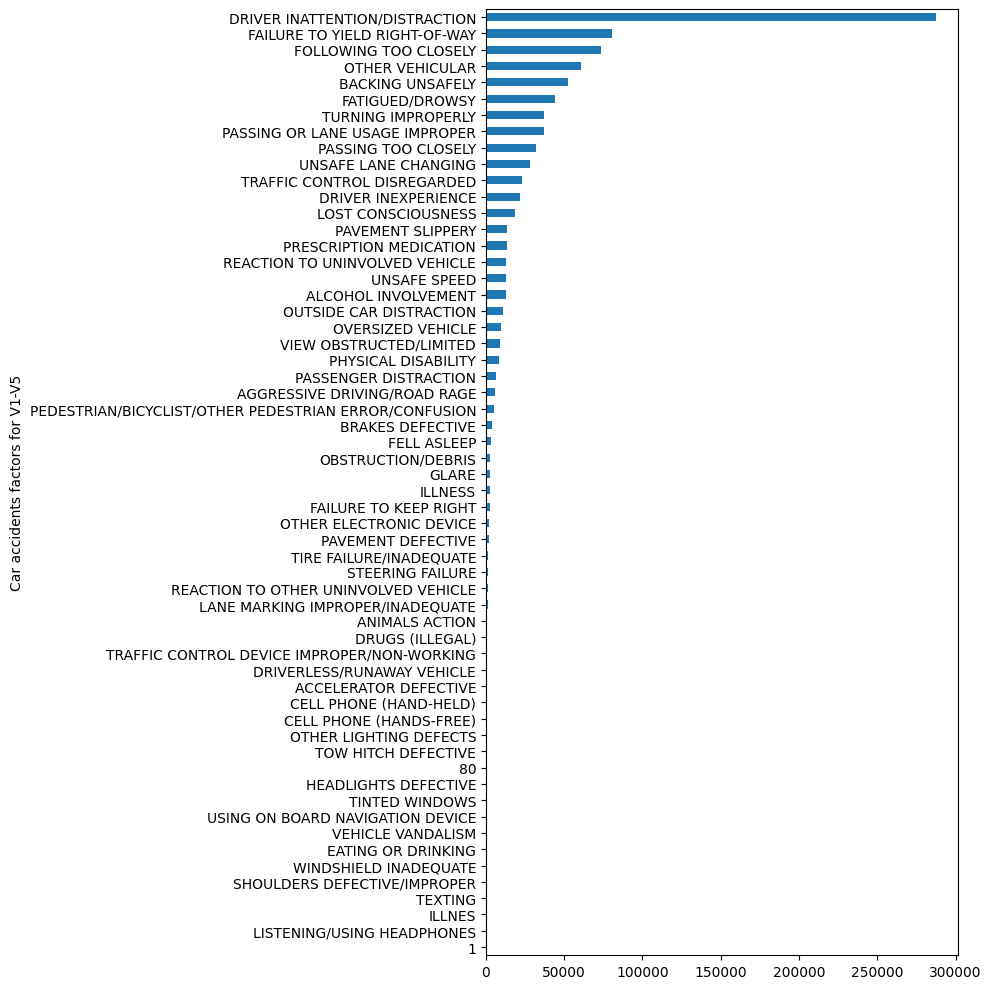

In [101]:
# Graphical visualization of car accidents factors for vehicle 1 up to 5
plt.figure(figsize=(10, 10))
vehicle_collision_transformed['CONTRIBUTING FACTOR V1-V5'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.ylabel('Car accidents factors for V1-V5')
plt.tight_layout()
plt.show()

## 4.1 Most dangerous factors by borough

In [102]:
# Grouping dataframe by 'BOROUGH' and 'CONTRIBUTING FACTOR V1-V5'
most_dangerous_factors = vehicle_collision_transformed.groupby(['BOROUGH','CONTRIBUTING FACTOR V1-V5']).size()
# Grouping by 'n largest' contributing factors 
most_dangerous_factors = most_dangerous_factors.groupby(level=0).nlargest(1).reset_index(level=0, drop=True)
# Data visualization (data type: 'series')
most_dangerous_factors

BOROUGH        CONTRIBUTING FACTOR V1-V5     
BRONX          DRIVER INATTENTION/DISTRACTION    22776
BROOKLYN       DRIVER INATTENTION/DISTRACTION    49127
MANHATTAN      DRIVER INATTENTION/DISTRACTION    54221
QUEENS         DRIVER INATTENTION/DISTRACTION    56542
STATEN ISLAND  DRIVER INATTENTION/DISTRACTION     7878
dtype: int64

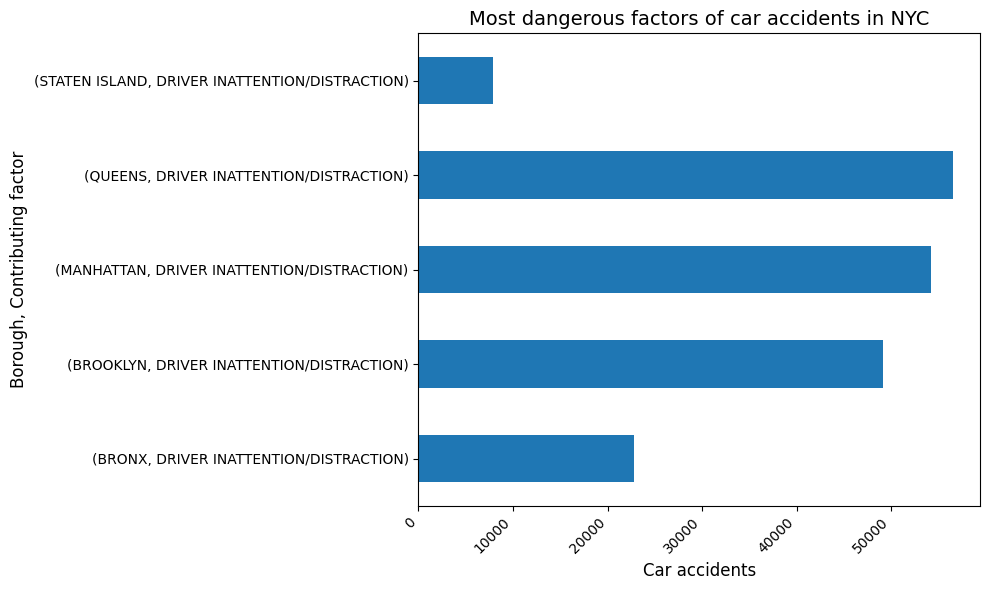

In [103]:
# Graphical visualization of most dangerous factors of car accidents in NYC
plt.figure(figsize = (10,6))
most_dangerous_factors.plot(kind='barh')
plt.title('Most dangerous factors of car accidents in NYC', fontsize=14)
plt.ylabel('Borough, Contributing factor', fontsize = 12)
plt.xlabel('Car accidents', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4.2 Impact of speeding

In [104]:
# Selecting only rows with 'UNSAFE SPEED' factor
unsafe_speed_data = vehicle_collision_transformed[vehicle_collision_transformed['CONTRIBUTING FACTOR V1-V5'] == 'UNSAFE SPEED']
# Grouping data by borough and summing up deaths and injuries
unsafe_speed_data = unsafe_speed_data.groupby('BOROUGH')[['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']].sum()
unsafe_speed_data

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED
BOROUGH,,
BRONX,856.0,3.0
BROOKLYN,1475.0,13.0
MANHATTAN,404.0,3.0
QUEENS,1189.0,22.0
STATEN ISLAND,217.0,2.0


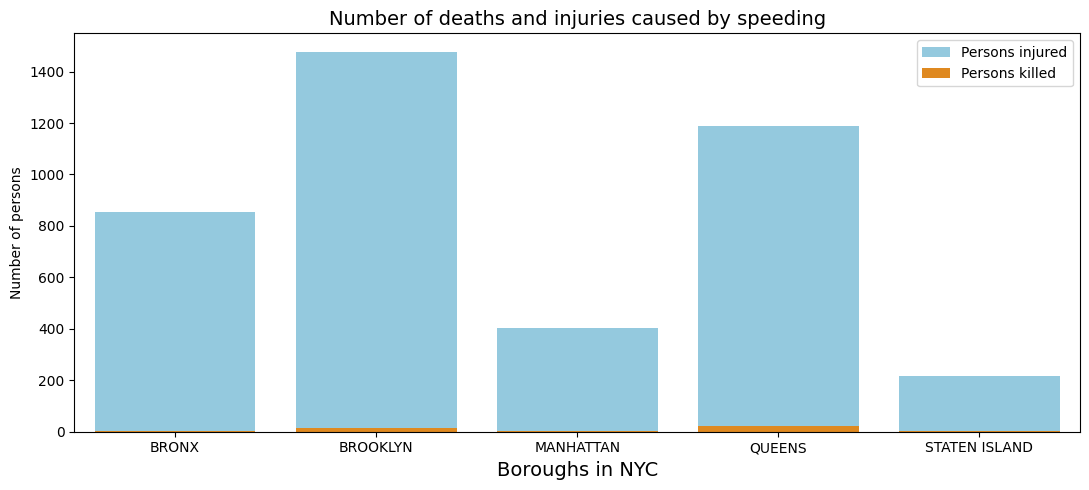

In [105]:
# Data vissualization using seaborn as sns
plt.figure(figsize=(11,5))
sns.barplot(data=unsafe_speed_data, x='BOROUGH', y='NUMBER OF PERSONS INJURED', color='skyblue', label='Persons injured')
sns.barplot(data=unsafe_speed_data, x='BOROUGH', y='NUMBER OF PERSONS KILLED', color='darkorange', label='Persons killed')
plt.title('Number of deaths and injuries caused by speeding', fontsize=14)
plt.xlabel('Boroughs in NYC', fontsize=14)
plt.ylabel('Number of persons')
plt.tight_layout()
plt.show()

In [106]:
# Another data visualization
fig = plt.figure(figsize=(10,6))
unsafe_speed_data.plot(kind='bar')
plt.title('Number of deaths and injuries caused by speeding')
plt.xlabel('Borough in NYC')
plt.ylabel('Number of persons')
plt.tight_layout()
plt.savefig('DataSets/Number_of_deaths_and_injuries.png')
plt.close()
# Showing graph on the middle of the screen
HTML("""
<div style="display: flex; justify-content: center;">
    <img src="DataSets/Number_of_deaths_and_injuries.png" alt="Wykres">
</div>
""")

<Figure size 1000x600 with 0 Axes>

In [107]:
unsafe_speed_data = unsafe_speed_data[['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']].sum()
unsafe_speed_data

NUMBER OF PERSONS INJURED    4141.0
NUMBER OF PERSONS KILLED       43.0
dtype: float64

In [108]:
# Selecting only rows with 'NUMBER OF PERSONS KILLED'
persons_killed_data = vehicle_collision_transformed.groupby('CONTRIBUTING FACTOR V1-V5')[['NUMBER OF PERSONS KILLED']].sum()
persons_killed_data

,NUMBER OF PERSONS KILLED
CONTRIBUTING FACTOR V1-V5,
1,0.0
80,0.0
ACCELERATOR DEFECTIVE,0.0
AGGRESSIVE DRIVING/ROAD RAGE,8.0
ALCOHOL INVOLVEMENT,46.0
ANIMALS ACTION,0.0
BACKING UNSAFELY,23.0
BRAKES DEFECTIVE,0.0
CELL PHONE (HAND-HELD),0.0


In [109]:
# Saving new dataframe 'unsafe speed data' to csv
unsafe_speed_data.to_csv('DataSets/unsafe_speed_data.csv')

## 4.3 Top accident factors

# Conclusions

1. Najczęściej występujaca przyczyna wypadkow w kazdym stanie jest: Driver inattention/distraction.
2. Nadmierna prędkość jest przyczyna z powodu której zginely (w analizowanym okresie 7 lat) 43 osoby, a 4141 zostały ranne.
   Nadmierna prędkość nie jest przyczyna z powodu której ginie najwięcej osób. Co jest przyczyna???